# AutoML Image Classification: 15m Challenge Added Noise (Digits)

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

![](imgs/gaussian_noise.png)

In [2]:
import random as rn
from abc import ABC, abstractmethod

import autokeras as ak
import h2o
import matplotlib.pyplot as plt
import numpy as np
from h2o.automl import H2OAutoML
from keras.datasets import fashion_mnist
from numpy.random import RandomState
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier

from dpemu import runner
from dpemu.filters.common import GaussianNoise, Clip
from dpemu.filters.image import RotationPIL
from dpemu.nodes import Array
from dpemu.nodes.series import Series
from dpemu.plotting_utils import visualize_scores, print_results_by_model
from dpemu.utils import generate_tmpdir

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


Using TensorFlow backend.


In [3]:
def get_data():
    random_state = RandomState(42)
    x, y = load_digits(return_X_y=True)
    y = y.astype(np.uint8)
    return train_test_split(x, y, test_size=1/7, random_state=random_state)
    # (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    # s = x_train.shape[1]
    # x_train = x_train.reshape((len(x_train), s**2)).astype(np.float64)
    # x_test = x_test.reshape((len(x_test), s**2)).astype(np.float64)    
    # return x_train, x_test, y_train, y_test

In [4]:
def get_err_root_node():
    err_img_node = Array(reshape=(8, 8))
    # err_img_node = Array(reshape=(28, 28))

    # err_root_node = Series(err_img_node)
    # err_img_node.addfilter(RotationPIL("max_angle"))
    # return err_root_node
    err_root_node = Series(err_img_node)
    err_img_node.addfilter(GaussianNoise("mean", "std"))
    err_img_node.addfilter(Clip("min_val", "max_val"))
    return err_root_node

In [5]:
def get_err_params_list(data):
    # angle_steps = np.linspace(0, 90, num=6)
    # err_params_list = [{"max_angle": a} for a in angle_steps]
    # return err_params_list
    min_val = np.amin(data)
    max_val = np.amax(data)
    std_steps = np.round(np.linspace(0, max_val, num=6), 3)
    err_params_list = [{"mean": 0, "std": std, "min_val": min_val, "max_val": max_val} for std in std_steps]
    return err_params_list

In [6]:
class Preprocessor:

    def run(self, train_data, test_data, params):
        return np.round(train_data).astype(np.uint8), np.round(test_data).astype(np.uint8), {}

In [7]:
class AbstractModel(ABC):

    def __init__(self):
        self.time_limit_mins = 15
        self.seed = 42
        self.random_state = RandomState(self.seed)
        np.random.seed(self.seed)

    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    @abstractmethod
    def get_accuracy(self, data, labels, fitted_model, params):
        pass

    @abstractmethod
    def get_best_pipeline(self, fitted_model):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        fitted_model = self.get_fitted_model(train_data, train_labels, params)

        results = {
            "test_acc": self.get_accuracy(test_data, test_labels, fitted_model, params),
            "train_acc": self.get_accuracy(train_data, train_labels, fitted_model, params),
            "best_pipeline": self.get_best_pipeline(fitted_model),
        }
        print(type(fitted_model))
        print(results["test_acc"])
        return results

class TPOTClassifierModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return TPOTClassifier(
            max_time_mins=self.time_limit_mins,
            max_eval_time_mins=self.time_limit_mins,
            n_jobs=-1,
            random_state=self.seed,
            verbosity=1,
        ).fit(train_data, train_labels)

    def get_accuracy(self, data, labels, fitted_model, params):
        return round(fitted_model.score(data, labels), 3)

    def get_best_pipeline(self, fitted_model):
        return [step[1] for step in fitted_model.fitted_pipeline_.steps]

class H2OAutoMLModel(AbstractModel):

    def __init__(self):
        super().__init__()
        h2o.init(name=f"#{rn.SystemRandom().randint(1, 2**30)}", nthreads=20)
        h2o.no_progress()

    def get_fitted_model(self, train_data, train_labels, params):
        train_data = h2o.H2OFrame(np.concatenate((train_data, train_labels.reshape(-1, 1)), axis=1))
        x = np.array(train_data.columns)[:-1].tolist()
        y = np.array(train_data.columns)[-1].tolist()
        train_data[y] = train_data[y].asfactor()
        aml = H2OAutoML(max_runtime_secs=60*self.time_limit_mins, seed=self.seed)
        aml.train(x=x, y=y, training_frame=train_data)
        return aml

    def get_accuracy(self, data, labels, fitted_model, params):
        data = h2o.H2OFrame(np.concatenate((data, labels.reshape(-1, 1)), axis=1))
        y = np.array(data.columns)[-1].tolist()
        data[y] = data[y].asfactor()
        pred = fitted_model.predict(data).as_data_frame(header=False)["predict"].values.astype(int)
        return np.round(np.mean(pred == labels), 3)

    def get_best_pipeline(self, fitted_model):
        leader_params = fitted_model.leader.get_params()
        best_pipeline = [leader_params["model_id"]["actual_value"]["name"]]
        if "base_models" in leader_params:
            for base_model in leader_params["base_models"]["actual_value"]:
                best_pipeline.append(base_model["name"])
        h2o.cluster().shutdown()
        return best_pipeline

class AutoKerasModel(AbstractModel):

    def __init__(self):
        super().__init__()
        import tensorflow as tf
        tf.set_random_seed(self.seed)
        import torch
        torch.multiprocessing.set_sharing_strategy("file_system")
        torch.manual_seed(self.seed)

    def get_fitted_model(self, x_train, y_train, params):
        s = np.sqrt(x_train.shape[1]).astype(int)
        x_train = x_train.reshape((len(x_train), s, s, 1))
        clf = ak.ImageClassifier(augment=False, path=generate_tmpdir(), verbose=False)
        clf.fit(x_train, y_train, time_limit=60*self.time_limit_mins)
        return clf

    def get_accuracy(self, x, y, clf, params):
        s = np.sqrt(x.shape[1]).astype(int)
        x = x.reshape((len(x), s, s, 1))
        y_pred = clf.predict(x)
        return np.round(accuracy_score(y_true=y, y_pred=y_pred), 3)

    def get_best_pipeline(self, clf):
        return [m for i, m in enumerate(clf.cnn.best_model.produce_model().modules()) if i > 0]

In [8]:
def get_model_params_dict_list(train_labels, test_labels):
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    return [
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
    ]

In [9]:
def visualize(df):
    visualize_scores(
        df,
        score_names=["test_acc", "train_acc"],
        is_higher_score_better=[True, True],
        # err_param_name="max_angle",
        err_param_name="std",
        title="Classification scores with added error"
    )
    plt.show()

In [10]:
train_data, test_data, train_labels, test_labels = get_data()

df = runner.run(
    train_data=train_data,
    test_data=test_data,
    preproc=Preprocessor,
    preproc_params=None,
    err_root_node=get_err_root_node(),
    # err_params_list=get_err_params_list(),
    err_params_list=get_err_params_list(train_data),
    model_params_dict_list=get_model_params_dict_list(train_labels, test_labels),
    n_processes=1
)

  0%|          | 0/6 [00:00<?, ?it/s]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.988

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.988

15.37 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(LogisticRegression(input_matrix, C=0.5, dual=False, penalty=l1), n_neighbors=12, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.984

15.59 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(LogisticRegression(input_matrix, C=0.5, dual=False, penalty=l1), n_neighbors=12, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.984

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpxr2z6fel

  JVM stdout: /wrk/users/thalvari/tmpxr2z6fel/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpxr2z6fel/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#187886847
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b17d closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.973

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp1k9l1ruk

  JVM stdout: /wrk/users/thalvari/tmp1k9l1ruk/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp1k9l1ruk/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#728410001
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_98e7 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.984

 17%|█▋        | 1/6 [1:33:13<7:46:05, 5593.16s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.895

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.942

16.18 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(LinearSVC(input_matrix, C=10.0, dual=False, loss=squared_hinge, penalty=l2, tol=0.0001), n_neighbors=12, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.957

15.36 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(LogisticRegression(input_matrix, C=0.5, dual=False, penalty=l1), n_neighbors=12, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.965

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpk2iy2_38

  JVM stdout: /wrk/users/thalvari/tmpk2iy2_38/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpk2iy2_38/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#652134232
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_9a37 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.93

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmptr84iyvn

  JVM stdout: /wrk/users/thalvari/tmptr84iyvn/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmptr84iyvn/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#97864931
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b106 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.86

 33%|███▎      | 2/6 [3:07:16<6:13:53, 5608.29s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.696

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.728

22.07 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(input_matrix, n_neighbors=70, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.825

15.33 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(LogisticRegression(input_matrix, C=0.5, dual=False, penalty=l1), n_neighbors=12, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.899

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp5fp2mpit

  JVM stdout: /wrk/users/thalvari/tmp5fp2mpit/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp5fp2mpit/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#310299227
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8fe2 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.802

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpfxk942ru

  JVM stdout: /wrk/users/thalvari/tmpfxk942ru/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpfxk942ru/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#511443949
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b9e6 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.541

 50%|█████     | 3/6 [4:47:21<4:46:21, 5727.12s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.463

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.486

16.17 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

MultinomialNB(XGBClassifier(input_matrix, learning_rate=0.1, max_depth=4, min_child_weight=9, n_estimators=100, nthread=1, subsample=0.6000000000000001), alpha=100.0, fit_prior=False)

<class 'tpot.tpot.TPOTClassifier'>

0.669

15.14 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(LogisticRegression(input_matrix, C=0.5, dual=False, penalty=l1), n_neighbors=12, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.728

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp7pkd_hrl

  JVM stdout: /wrk/users/thalvari/tmp7pkd_hrl/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp7pkd_hrl/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#988592068
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b63a closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.689

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpa62c1ecw

  JVM stdout: /wrk/users/thalvari/tmpa62c1ecw/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpa62c1ecw/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#190106896
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_9704 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.339

 67%|██████▋   | 4/6 [6:21:31<3:10:08, 5704.23s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.342

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.346

15.39 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

GaussianNB(MultinomialNB(SelectPercentile(input_matrix, percentile=67), alpha=0.001, fit_prior=True))

<class 'tpot.tpot.TPOTClassifier'>

0.498

15.66 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(LogisticRegression(input_matrix, C=0.5, dual=False, penalty=l1), n_neighbors=12, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.533

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpeb8hopca

  JVM stdout: /wrk/users/thalvari/tmpeb8hopca/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpeb8hopca/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#1024128550
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_a145 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.482

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp25_u5gwj

  JVM stdout: /wrk/users/thalvari/tmp25_u5gwj/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp25_u5gwj/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#2352767
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b284 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.428

 83%|████████▎ | 5/6 [7:52:24<1:33:48, 5628.87s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.222

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.257

16.84 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

MultinomialNB(RFE(input_matrix, criterion=gini, max_features=0.4, n_estimators=100, step=0.8), alpha=10.0, fit_prior=False)

<class 'tpot.tpot.TPOTClassifier'>

0.358

15.23 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(LogisticRegression(input_matrix, C=0.5, dual=False, penalty=l1), n_neighbors=12, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.377

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpl0mm20yz

  JVM stdout: /wrk/users/thalvari/tmpl0mm20yz/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpl0mm20yz/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#272016698
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b075 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.346

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp3k6jpo94

  JVM stdout: /wrk/users/thalvari/tmp3k6jpo94/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp3k6jpo94/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#1060273213
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_9b90 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.171

100%|██████████| 6/6 [9:24:13<00:00, 5592.84s/it]  

100%|██████████| 6/6 [9:24:13<00:00, 5642.29s/it]

'AutoKeras #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.988,0.999,0.149,0.001,902.195
3.2,0.895,0.984,0.096,0.001,901.8
6.4,0.696,0.874,0.102,0.002,901.585
9.6,0.463,0.923,0.135,0.001,911.516
12.8,0.342,0.845,0.129,0.001,908.317
16,0.222,0.697,0.098,0.001,906.439


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75
0,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),GlobalAvgPool2d(),"Linear(in_features=512, out_features=10, bias=True)"
3.2,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine

'AutoKerasClean #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.988,0.999,0.149,0.001,903.8
3.2,0.942,0.999,0.096,0.001,905.834
6.4,0.728,0.999,0.102,0.002,905.856
9.6,0.486,0.999,0.135,0.001,904.61
12.8,0.346,0.999,0.129,0.001,904.732
16,0.257,0.999,0.098,0.001,916.142


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75
0,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),GlobalAvgPool2d(),"Linear(in_features=512, out_features=10, bias=True)"
3.2,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padd

'H2OAutoML #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.973,1,0.149,0.001,961.124
3.2,0.93,1,0.096,0.001,965.329
6.4,0.802,1,0.102,0.002,994
9.6,0.689,0.999,0.135,0.001,988.709
12.8,0.482,1,0.129,0.001,785.375
16,0.346,0.482,0.098,0.001,794.191


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80,pipe_81,pipe_82,pipe_83,pipe_84,pipe_85,pipe_86,pipe_87,pipe_88,pipe_89,pipe_90,pipe_91,pipe_92,pipe_93,pipe_94,pipe_95,pipe_96,pipe_97,pipe_98,pipe_99,pipe_100,pipe_101,pipe_102
0,StackedEnsemble_BestOfFamily_AutoML_20191119_154149,DeepLearning_grid_1_AutoML_20191119_154149_model_6,GBM_grid_1_AutoML_20191119_154149_model_39,XGBoost_grid_1_AutoML_20191119_154149_model_13,DRF_1_AutoML_20191119_154149,XRT_1_AutoML_20191119_154149,GLM_grid_1_AutoML_20191119_154149_model_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3.2,StackedEnsemble_BestOfFamily_AutoML_20191119_171536,GBM_grid_1_AutoML_20191119_171536_model_31,DeepLearning_grid_1_AutoML_20191119_171536_model_2,XGBoost_grid_1_AutoML_20191119_171536_model_13,DRF_1_AutoML_20191119_171536,XRT_1_AutoML_20191119_171536,GLM_grid_1_AutoML_20191119_171536_model_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6.4,StackedEnsemble_AllModels_AutoML_20191119_185531,DeepLearning_grid_1_AutoML_20191119_185531_model_2,DeepLearning_grid_1_AutoML_20191119_185531_model_6,DeepLearning_grid_1_AutoML_20191119_185531_model_9,DeepLearning_grid_1_AutoML_20191119_185531_model_1,GLM_grid_1_AutoML_20191119_185531_model_1,XGBoost_1_AutoML_20191119_185531,DeepLearning_grid_1_AutoML_20191119_185531_model_5,DeepLearning_grid_1_AutoML_20191119_185531_model_3,GBM_grid_1_AutoML_20191119_185531_model_31,XGBoost_grid_1_AutoML_20191119_185531_model_20,GBM_grid_1_AutoML_20191119_185531_model_20,XGBoost_grid_1_AutoML_20191119_185531_model_18,XGBoost_3_AutoML_20191119_185531,GBM_grid_1_AutoML_20191119_185531_model_27,XGBoost_grid_1_AutoML_20191119_185531_model_2,XGBoost_grid_1_AutoML_20191119_185531_model_7,GBM_grid_1_AutoML_20191119_185531_model_15,XGBoost_grid_1_AutoML_20191119_185531_model_8,GBM_grid_1_AutoML_20191119_185531_model_19,GBM_4_AutoML_20191119_185531,XGBoost_grid_1_AutoML_20191119_185531_model_21,XGBoost_grid_1_AutoML_20191119_185531_model_15,XGBoost_2_AutoML_20191119_185531,XGBoost_grid_1_AutoML_20191119_185531_model_17,GBM_grid_1_AutoML_20191119_185531_model_8,GBM_grid_1_AutoML_20191119_185531_model_17,GBM_grid_1_AutoML_20191119_185531_model_29,GBM_grid_1_AutoML_20191119_185531_model_6,GBM_grid_1_AutoML_20191119_185531_model_1,GBM_2_AutoML_20191119_185531,GBM_grid_1_AutoML_20191119_185531_model_26,GBM_grid_1_AutoML_20191119_185531_model_12,GBM_grid_1_AutoML_20191119_185531_model_21,GBM_grid_1_AutoML_20191119_185531_model_13,GBM_grid_1_AutoML_20191119_185531_model_14,XGBoost_grid_1_AutoML_20191119_185531_model_13,XGBoost_grid_1_AutoML_20191119_185531_model_19,XGBoost_grid_1_AutoML_20191119_185531_model_5,GBM_1_AutoML_20191119_185531,XGBoost_grid_1_AutoML_20191119_185531_model_4,GBM_grid_1_AutoML_20191119_1855

'H2OAutoMLClean #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.984,1,0.149,0.001,963.986
3.2,0.86,1,0.096,0.001,975.22
6.4,0.541,1,0.102,0.002,956.36
9.6,0.339,1,0.135,0.001,958.191
12.8,0.428,1,0.129,0.001,989.783
16,0.171,1,0.098,0.001,962.702


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80,pipe_81,pipe_82,pipe_83,pipe_84,pipe_85,pipe_86,pipe_87,pipe_88,pipe_89,pipe_90,pipe_91,pipe_92,pipe_93,pipe_94,pipe_95,pipe_96,pipe_97,pipe_98,pipe_99
0,StackedEnsemble_BestOfFamily_AutoML_20191119_155749,GBM_grid_1_AutoML_20191119_155749_model_39,DeepLearning_grid_1_AutoML_20191119_155749_model_2,XGBoost_grid_1_AutoML_20191119_155749_model_13,DRF_1_AutoML_20191119_155749,XRT_1_AutoML_20191119_155749,GLM_grid_1_AutoML_20191119_155749_model_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3.2,StackedEnsemble_BestOfFamily_AutoML_20191119_173142,DeepLearning_grid_1_AutoML_20191119_173142_model_6,GBM_grid_1_AutoML_20191119_173142_model_39,XGBoost_grid_1_AutoML_20191119_173142_model_13,DRF_1_AutoML_20191119_173142,XRT_1_AutoML_20191119_173142,GLM_grid_1_AutoML_20191119_173142_model_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6.4,StackedEnsemble_BestOfFamily_AutoML_20191119_191204,DeepLearning_grid_1_AutoML_20191119_191204_model_9,GBM_grid_1_AutoML_20191119_191204_model_39,XGBoost_grid_1_AutoML_20191119_191204_model_13,DRF_1_AutoML_20191119_191204,XRT_1_AutoML_20191119_191204,GLM_grid_1_AutoML_20191119_191204_model_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
9.6,StackedEnsemble_BestOfFamily_AutoML_20191119_204613,DeepLearning_grid_1_AutoML_20191119_204613_model_2,GBM_grid_1_AutoML_20191119_204613_model_39,XGBoost_grid_1_AutoML_20191119_204613_model_13,DRF_1_AutoML_20191119_204613,XRT_1_AutoML_20191119_204613,GLM_grid_1_AutoML_20191119_204613_model_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
12.8,StackedEnsemble_AllModels_AutoML_20191119_221635,GBM_grid_1_AutoML_20191119_221635_model_39,DeepLearning_grid_1_AutoML_20191119_221635_model_10,DeepLearning_grid_1_AutoML_20191119_221635_model_2,DeepLearning_grid_1_AutoML_20191119_221635_model_7,GBM_grid_1_AutoML_20191119_221635_model_31,GBM_grid_1_AutoML_20191119_221635_model_35,GBM_grid_1_AutoML_20191119_221635_model_18,DeepLearning_grid_1_AutoML_20191119_221635_model_1,GBM_grid_1_AutoML_20191119_221635_model_12,GBM_3_AutoML_20191119_221635,GBM_grid_1_AutoML_20191119_22

'TPOTClassifier #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.984,1,0.149,0.001,924.05
3.2,0.957,1,0.096,0.001,972.35
6.4,0.825,1,0.102,0.002,1325.36
9.6,0.669,0.737,0.135,0.001,977.832
12.8,0.498,0.506,0.129,0.001,924.061
16,0.358,0.418,0.098,0.001,1013.54


std,pipe_0,pipe_1,pipe_2
0,"StackingEstimator(estimator=LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=12, p=2, weights='distance')",nan
3.2,"StackingEstimator(estimator=LinearSVC(C=10.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=42, tol=0.0001, verbose=0))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=12, p=2, weights='distance')",nan
6.4,"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=70, p=2, weights='distance')",nan,nan
9.6,"StackingEstimator(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4, min_child_weight=9, missing=nan, n_estimators=100, n_jobs=1, nthread=1, objective='multi:softprob', random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=0.6000000000000001, verbosity=1))","MultinomialNB(alpha=100.0, class_prior=None, fit_prior=False)",nan
12.8,"SelectPercentile(percentile=67, score_func=)","StackingEstimator(estimator=MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True))","GaussianNB(priors=None, var_smoothing=1e-09)"
16,"RFE(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini', max_depth=None, max_features=0.4, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False), n_features_to_select=None, step=0.8, verbose=0)","MultinomialNB(alpha=10.0, class_prior=None, fit_prior=False)",nan


'TPOTClassifierClean #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.984,1,0.149,0.001,937.412
3.2,0.965,1,0.096,0.001,922.867
6.4,0.899,1,0.102,0.002,920.957
9.6,0.728,1,0.135,0.001,909.364
12.8,0.533,1,0.129,0.001,940.722
16,0.377,1,0.098,0.001,915.157


std,pipe_0,pipe_1
0,"StackingEstimator(estimator=LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=12, p=2, weights='distance')"
3.2,"StackingEstimator(estimator=LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=12, p=2, weights='distance')"
6.4,"StackingEstimator(estimator=LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=12, p=2, weights='distance')"
9.6,"StackingEstimator(estimator=LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=12, p=2, weights='distance')"
12.8,"StackingEstimator(estimator=LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=12, p=2, weights='distance')"
16,"StackingEstimator(estimator=LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=12, p=2, weights='distance')"


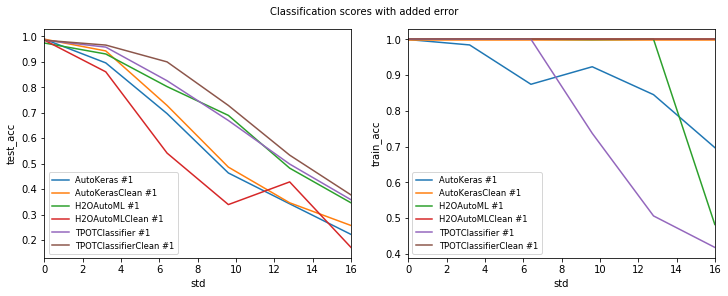

In [11]:
print_results_by_model(df,
    # ["train_labels", "test_labels"],
    ["mean", "min_val", "max_val", "train_labels", "test_labels"], 
    # err_param_name="max_angle",
    err_param_name="std",
    pipeline_name="best_pipeline"
)
visualize(df)